In [1]:
import itertools
import os
import numpy as np
import pandas as pd
import sqlite3 as sql

import matplotlib.pyplot as plt

# Create Example Database

## Generate Data

## Create DB

In [2]:
con = sql.connect('example.db')
cur = con.cursor()

## Insert generated data

# Different Visualisations

In [3]:
# Take 1 username for exaples
username = cur.execute("SELECT username FROM players;").fetchone()[0]
username

'@lUuwn'

## Default player statistics

Here I defind given player's winrate by defferent roles.

In [4]:
def get_player_answers(cur, username):
    """
    Returns table of player with given username results grouped by his answers
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
    
    Returns:
    --------
    res : dict
        Keys are answers, values are count numbers
    """
    query = f"""SELECT Records.role AS answer, COUNT(*) AS count
                FROM Records
                INNER JOIN Players ON Players.id = Records.player_id
                WHERE Players.username = '{username}'
                GROUP BY Records.role;"""
    res = cur.execute(query).fetchall()
    res = {i[0] : i[1] for i in res}
    for key in ['HC', 'HD', 'HL', 'HW', 'FL', 'LL', 'LW', 'FW']:
        try:
            res[key]
        except KeyError:
            res.update({key : 0})
    return res

In [5]:
def drow_username_winrate(cur, username, ax=None):
    """
    Plots a winrate statistics for given player.
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
    
    ax : matplotlib axes object, default None
        An axes of the current figure
    """
    info = get_player_answers(cur, username)
    bins = pd.DataFrame([[info['LW'], info['LL']], 
                         [info['FW'], info['FL']], 
                         [info['HC'] + info['HW'], info['HD'] + info['HL']]], 
                        columns=['Wins', 'Loses'], 
                        index=['Liberal', 'Fascist', 'Hitler']).transpose()
    
    bins.plot(kind='bar', stacked=True, color=['deepskyblue', 'orangered', 'darkred'], rot='horizontal', ax=ax)

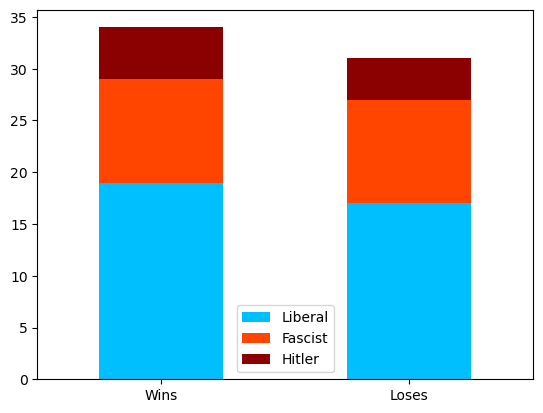

In [6]:
drow_username_winrate(cur, username)

## Best&worst players

Hare I try to define functions drowing stats with best and worst teammates opponents

In [7]:
def get_players_stats(cur, order='DESC', top=None):
    """
    Returns table containing number of wins and loses for each role and winrate
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    order : str values 'DESC' or 'ASC'
    
    top : uint or None
        function returns top n number of results, if that's not None  
    
    Retuens:
    --------
    res : DataFrame
        Columns: username, 
                 LW (liberal wins), 
                 FW (fascist wins), 
                 HW (Hitler wins), 
                 LL (liberal loses), 
                 FL (fascist loses), 
                 HL (Hitler loses), 
                 winrate
    """
    query = f"""SELECT username,
            SUM(CASE WHEN role = 'LW' THEN 1 ELSE 0 END) AS LW,
            SUM(CASE WHEN role = 'FW' THEN 1 ELSE 0 END) AS FW,
            SUM(CASE WHEN role IN ('HW', 'HC') THEN 1 ELSE 0 END) AS HW,
            SUM(CASE WHEN role = 'LL' THEN 1 ELSE 0 END) AS LL,
            SUM(CASE WHEN role = 'FL' THEN 1 ELSE 0 END) AS FL, 
            SUM(CASE WHEN role IN ('HL', 'HD') THEN 1 ELSE 0 END) AS HL,
            AVG(CASE WHEN role IN ('LW', 'FW', 'HW', 'HC') THEN 1 ELSE 0 END) AS winrate
            FROM records
            INNER JOIN players ON players.id = records.player_id
            GROUP BY player_id ORDER BY winrate {order};"""
    if top is not None:
        query = query[:-1] + f'\nLIMIT {top};'
    res = cur.execute(query).fetchall()
    res = pd.DataFrame(res, columns=['username', 'LW', 'FW', 'HW', 'LL', 'FL', 'HL', 'winrate'])
    return res

In [8]:
df = get_players_stats(cur, top=4)
df

,username,LW,FW,HW,LL,FL,HL,winrate
0,@KvbOP,17,8,8,10,5,0,0.687500
1,@nesHu,19,10,2,11,5,4,0.607843
2,@itmfR,21,9,5,14,7,3,0.593220
3,@zbfeU,27,7,3,18,6,4,0.569231


In [9]:
def draw_topest_players(cur, n=4, best=True, normolize=True, ax=None):
    """
    Draw hists for top best or worst players by winrate
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    n : int
        Number of players
    
    best : bool
        If True, draws best players
        If False, draws worst players
        
    normolize : bool
        Normolize values to sum be 1 for each player
    
    ax : matplotlib axes object, default None
        An axes of the current figure
    """
    order = {True: "DESC", False: "ASC"}[best]
    df = get_players_stats(cur, order=order, top=n)[::-1]
    df.index = df['username']
    df = df[['LW', 'FW', 'HW', 'LL', 'FL', 'HL']]
    df.columns = ['Liberal wins', 'Fascist wins', 'Hitler wins',
                  'Liberal loses', 'Fascist loses', 'Hitler loses']
    if normolize:
        df = df.transpose()
        df = df / df.sum()
        df = df.transpose()
    df.plot(kind='barh', stacked=True, color=['deepskyblue', 'orangered', 'darkred', 
                                              'lightblue', 'lightpink', 'rosybrown'], ax=ax, ylabel='')

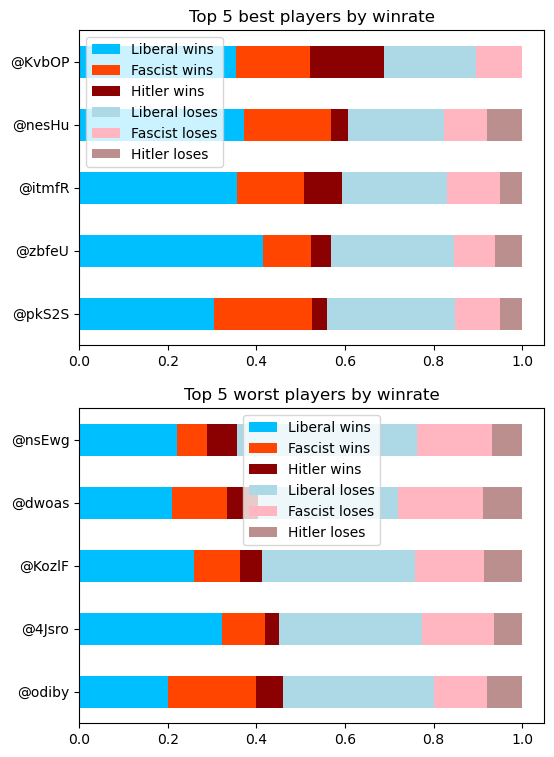

In [10]:
n = 5
fig, (ax0, ax1) = plt.subplots(2, 1)
fig.set_figheight(9)
fig.set_figwidth(6)

ax0.set_title(f'Top {n} best players by winrate')
draw_topest_players(cur, n, best=True, ax=ax0, normolize=True)

ax1.set_title(f'Top {n} worst players by winrate')
draw_topest_players(cur, n, best=False, ax=ax1, normolize=True)


## Best&worst teammates&opponents

Hare I try to define functions drowing stats with best and worst teammates opponents

In [11]:
def get_connection_stats(cur, username, order='DESC', top=None, which='teammate'):
    """
    Returns table containing number of wins and loses for each role and winrate
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
        
    order : str values 'DESC' or 'ASC'
    
    top : uint or None
        Function will return top n number of results, if that's not None  
    
    which: str or None
        Define which stats this function will return:
        'teammate' : teammates stats, 
        'opponent' : opponents stats,
        None : full stats
    
    Returns:
    --------
    res : DataFrame
        Columns: username, 
                 LW - Wins playing in liberal team
                 LL - Loses playing in liberal team
                 FW - Wins playing in fascist team
                 FL - Loses playing in fascist team
                 winrate
    """
    query_which = {None: '', 
                   'teammate': "\nAND ((records.role in ('LW', 'LL') AND w.team = 'Liberal') OR (records.role IN ('FW', 'FL', 'HC', 'HL') AND w.team = 'Fascist'))", 
                   'opponent': "\nAND ((records.role in ('LW', 'LL') AND w.team = 'Fascist') OR (records.role IN ('FW', 'FL', 'HC', 'HL') AND w.team = 'Liberal'))"
                  }[which]
    if top is None:
        query_limit = ''
    else:
        query_limit = f'\nLIMIT {top}'
    query = f"""WITH w(game_id, team, result) AS (SELECT records.game_id, 
                CASE WHEN records.role IN ('LL', 'LW') THEN 'Liberal' ELSE 'Fascist' END AS team, 
                CASE WHEN records.role IN ('FW', 'LW', 'HC', 'HW') THEN 'Win' ELSE 'Lose' END AS result
                FROM records INNER JOIN players ON players.id = records.player_id 
                WHERE players.username = '{username}')
                SElECT players.username, 
                SUM(CASE WHEN team = 'Liberal' AND result = 'Win' THEN 1 ELSE 0 END) AS LW, 
                SUM(CASE WHEN team = 'Fascist' AND result = 'Win' THEN 1 ELSE 0 END) AS FW, 
                SUM(CASE WHEN team = 'Liberal' AND result = 'Lose' THEN 1 ELSE 0 END) AS LL, 
                SUM(CASE WHEN team = 'Fascist' AND result = 'Lose' THEN 1 ELSE 0 END) AS FL, 
                AVG(CASE WHEN result = 'Win' THEN 1 ELSE 0 END) AS Winrate
                FROM records 
                INNER JOIN w ON w.game_id = records.game_id 
                INNER JOIN players ON players.id = records.player_id
                WHERE players.username != '{username}'{query_which}
                GROUP BY records.player_id
                ORDER BY Winrate {order}{query_limit};"""
    res = cur.execute(query).fetchall()
    res = pd.DataFrame(res, columns=['username', 'LW', 'LL', 'FW', 'FL', 'winrate'])
    return res

In [12]:
get_connection_stats(cur, username, order='DESC', top=8, which='teammate')

,username,LW,LL,FW,FL,winrate
0,@yzxnw,2,1,1,0,0.750000
1,@gjECr,5,0,1,1,0.714286
2,@uic3A,7,1,2,2,0.666667
3,@zbfeU,5,1,2,1,0.666667
4,@KvbOP,3,3,2,1,0.666667
5,@SxpbF,5,0,2,1,0.625000
6,@itmfR,2,1,2,0,0.600000
7,@dwoas,3,0,2,0,0.600000


In [13]:
def draw_connection_stats(cur, username, n=4, best=True, which='teammate', normolize=True, ax=None):
    """
    Draw hists for top best or worst players by winrate
    
    Parameters:
    -----------
    cur : sqlite3 cursor
        Cursor to the given database.
        
    username : string from table Players.username
        Username of given player.
    
    n : int
        Number of players
    
    best : bool
        If True, draws best players
        If False, draws worst players
        
    which: str or None
        Define which stats this function will return:
        'teammate' : teammates stats, 
        'opponent' : opponents stats,
        None : full stats
        
    normolize : bool
        Normolize values to sum be 1 for each player
    
    ax : matplotlib axes object, default None
        An axes of the current figure
    """
    order = {True: "DESC", False: "ASC"}[best]
    df = get_connection_stats(cur, username, order=order, top=n, which=which)[::-1]
    df.index = df['username']
    df = df[['LW', 'LL', 'FW', 'FL']]
    df.columns = ['Liberal wins', 'Fascist wins', 
                  'Liberal loses', 'Fascist loses']
    if normolize:
        df = df.transpose()
        df = df / df.sum()
        df = df.transpose()
    df.plot(kind='barh', stacked=True, color=['deepskyblue', 'orangered', 
                                              'lightblue', 'lightpink'], ax=ax, ylabel='')

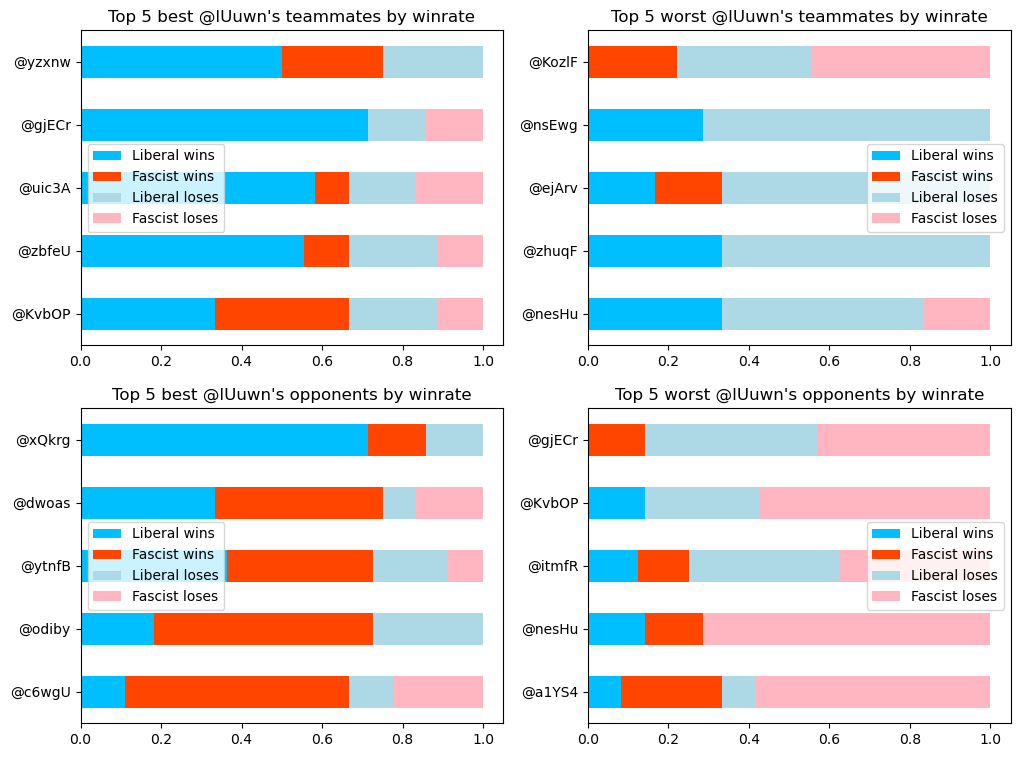

In [14]:
n = 5
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)
fig.set_figheight(9)
fig.set_figwidth(12)

ax0.set_title(f"Top {n} best {username}'s teammates by winrate")
draw_connection_stats(cur, username, n=n, best=True, which='teammate', normolize=True, ax=ax0)

ax1.set_title(f"Top {n} worst {username}'s teammates by winrate")
draw_connection_stats(cur, username, n=n, best=False, which='teammate', normolize=True, ax=ax1)

ax2.set_title(f"Top {n} best {username}'s opponents by winrate")
draw_connection_stats(cur, username, n=n, best=True, which='opponent', normolize=True, ax=ax2)


ax3.set_title(f"Top {n} worst {username}'s opponents by winrate")
draw_connection_stats(cur, username, n=n, best=False, which='opponent', normolize=True, ax=ax3)
